# Part 3, Model 3: Glaucoma Detection using K-Nearest Neighbors (KNN), XgBoost and a linear C-Support Vector Classification (SVM classifier) on the fundus, the optic cup, and the optic disk images of the eye + calculated OC feature + calculated OD feature + computed I-GRI (Integrated Glaucoma Risk Index) feature (predictive imputation used to fill up NaN values) using statistical analysis. The features were extracted using the MobileNetV3 model.

In [1]:
%pip install scikit-learn
%pip install seaborn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler  
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf

from pathlib import Path

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

2024-03-28 12:21:41.102171: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 12:21:41.102331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 12:21:41.139084: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 12:21:41.324468: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 12:21:43.353950: W tensorflow/compiler/tf2

In [3]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('metadata - standardized.csv')

In [4]:
data.columns

Index(['names', 'types', 'type_expanded', 'isColor', 'original_name',
       'patient_id', 'fundus', 'fundus_od_seg', 'fundus_oc_seg', 'bv_seg',
       'artery_seg', 'vein_seg', 'oct', 'oct_oc_seg', 'oct_od_seg', 'sex',
       'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr',
       'Unnamed: 24', 'notchI_present', 'notchS_present', 'notchN_present',
       'notchT_present', 'expert1_grade', 'expert2_grade', 'expert3_grade',
       'expert4_grade', 'expert5_grade', 'cdr_avg', 'cdr_expert1',
       'cdr_expert2', 'cdr_expert3', 'cdr_expert4', 'refractive_dioptre_1',
       'refractive_dioptre_2', 'refractive_astigmatism',
       'phakic_or_pseudophakic', 'iop_perkins', 'iop_pneumatic', 'pachymetry',
       'axial_length', 'visual_field_mean_defect'],
      dtype='object')

In [5]:
data.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [7]:
print(data['fundus'][12044])
print(data['fundus_oc_seg'][12044])
print(data['fundus_od_seg'][12044])

/full-fundus/PAPILA-484.png
/optic-cup/PAPILA-484.png
/optic-disc/PAPILA-484.png


full-fundus/full-fundus/PAPILA-484.png


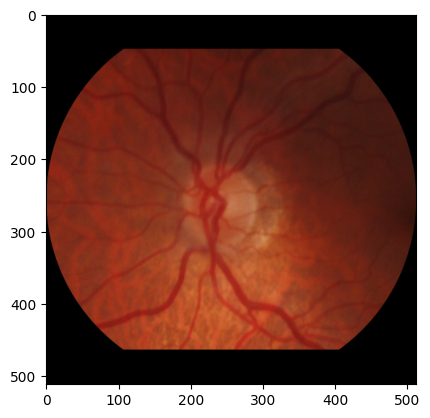

optic-cup/optic-cup/PAPILA-484.png


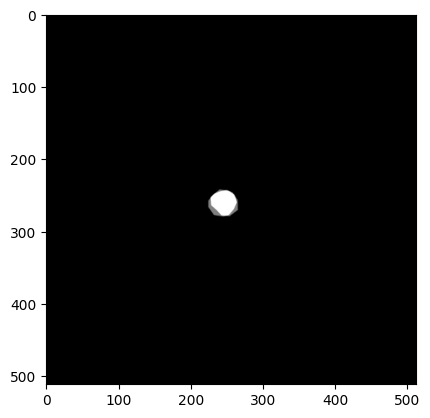

optic-disc/optic-disc/PAPILA-484.png


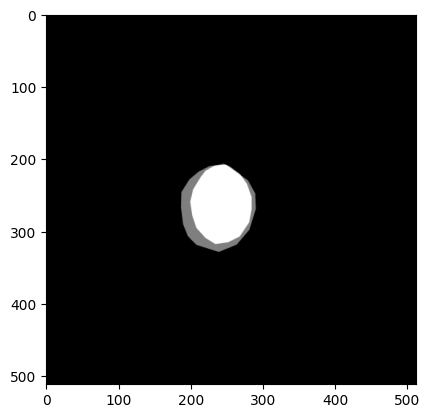

In [8]:
def viewFundus(image_path):

    image_path = 'full-fundus' + image_path

    print(image_path)

    image = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('on')
    plt.show()

def viewOpticCup(image_path):

    image_path = 'optic-cup' + image_path

    print(image_path)

    image = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('on')
    plt.show()

def viewOpticDisc(image_path):

    image_path = 'optic-disc' + image_path

    print(image_path)

    image = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('on')
    plt.show()


viewFundus(data['fundus'][12044])
viewOpticCup(data['fundus_oc_seg'][12044])
viewOpticDisc(data['fundus_od_seg'][12044])

In [9]:
data.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [11]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

data = data.dropna(axis=1, how='all')

data['eye'] = data['eye'].replace({'OD': 0, 'OS': 1})

for col in ['gender', 'eye']:
    if col in data.columns:
        mode = data[col].mode()[0]
        data[col] = data[col].fillna(mode)

numerical_data = data.select_dtypes(include=[np.number])

rf_regressor = RandomForestRegressor(
    n_estimators=150,
    max_features='sqrt',
    n_jobs=-1,
    random_state=None
)

imp = IterativeImputer(
    estimator=rf_regressor,
    max_iter=10,
    random_state=None
)

numerical_data_imputed = imp.fit_transform(numerical_data)

numerical_data_imputed = pd.DataFrame(numerical_data_imputed, columns=numerical_data.columns, index=numerical_data.index)

integer_columns = ['types', 'isColor', 'gender', 'eye', 'age']
for col in integer_columns:
    if col in numerical_data_imputed.columns:
        numerical_data_imputed[col] = numerical_data_imputed[col].round().astype('Int64')

non_numerical_data = data.select_dtypes(exclude=[np.number])
data_imputed = pd.concat([numerical_data_imputed, non_numerical_data], axis=1)

data_imputed = data_imputed.loc[data.index]

print("Shape of imputed data:", data_imputed.shape)

Shape of imputed data: (12449, 47)


/root/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [12]:
print(data_imputed.describe())

          types  isColor    gender        age       eye           sbp  \
count   12449.0  12449.0   12449.0    12449.0   12449.0  12449.000000   
mean   0.372239      1.0  0.985059  60.299221   0.77444    210.035958   
std    0.505039      0.0  0.121322   8.460717  0.417968     77.276513   
min        -1.0      1.0       0.0        1.0       0.0    107.000000   
25%         0.0      1.0       1.0       58.0       1.0    140.160000   
50%         0.0      1.0       1.0       62.0       1.0    150.586667   
75%         1.0      1.0       1.0       65.0       1.0    306.880000   
max         1.0      1.0       1.0       91.0       1.0    412.000000   

                dbp            hr           iop          vcdr  ...  \
count  12449.000000  12449.000000  12449.000000  12449.000000  ...   
mean      77.427491     65.132342     15.189805      0.573688  ...   
std        6.564589      4.921505      2.964318      0.117757  ...   
min       47.000000     51.000000      8.000000      0.161000 

In [13]:
data = data_imputed

data.tail()

,types,isColor,gender,age,eye,sbp,dbp,hr,iop,vcdr,...,sex,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
12444,0,1,1,58,1,306.88,81.086667,67.646667,17.193333,0.369353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12445,0,1,1,58,1,306.88,81.086667,67.646667,17.193333,0.369353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12446,0,1,1,58,1,306.88,81.086667,67.646667,17.193333,0.369353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12447,0,1,1,58,1,306.88,81.086667,67.646667,17.193333,0.369353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12448,0,1,1,58,1,306.88,81.086667,67.646667,17.193333,0.369353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


optic-cup/optic-cup/PAPILA-484.png
optic-cup/optic-cup/PAPILA-484.png


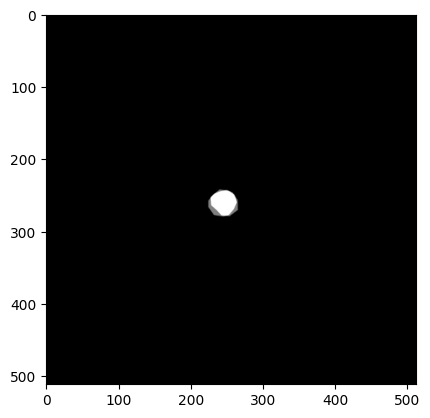

Normalized OC Area: 0.004856109619140625


In [14]:
import cv2
import numpy as np

def compute_normalized_area_optic_cup(masked_image_path):

    try:

        masked_image_path = 'optic-cup' + masked_image_path

        print(masked_image_path)

        masked_image = cv2.imread(masked_image_path)
        
        gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

        _, binary_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

        white_area = np.sum(binary_mask == 255)

        total_pixels = masked_image.shape[0] * masked_image.shape[1]
        
        normalized_area = white_area / total_pixels

        return normalized_area
    
    except Exception as e:
        
        print(f"Skipping: Error processing image at {masked_image_path}: {e}")
        return None

normalized_area = compute_normalized_area_optic_cup(data['fundus_oc_seg'][12044])

viewOpticCup(data['fundus_oc_seg'][12044])

print(f"Normalized OC Area: {normalized_area}")

optic-disc/optic-disc/PAPILA-484.png
optic-disc/optic-disc/PAPILA-484.png


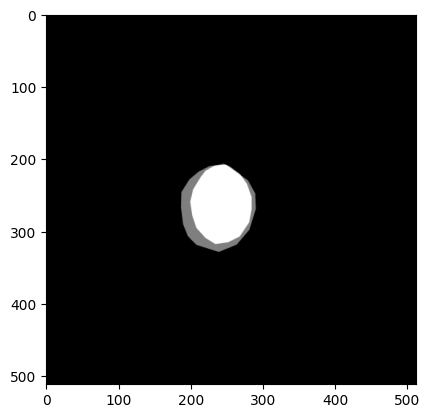

Normalized OD Area: 0.037567138671875


In [15]:
import cv2
import numpy as np

def compute_normalized_area_optic_disc(masked_image_path):

    try:

        masked_image_path = 'optic-disc' + masked_image_path

        print(masked_image_path)

        masked_image = cv2.imread(masked_image_path)
        
        gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

        _, binary_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

        white_area = np.sum(binary_mask == 255)

        total_pixels = masked_image.shape[0] * masked_image.shape[1]
        
        normalized_area = white_area / total_pixels

        return normalized_area
    
    except Exception as e:
        
        print(f"Skipping: Error processing image at {masked_image_path}: {e}")
        return None

normalized_area = compute_normalized_area_optic_disc(data['fundus_od_seg'][12044])

viewOpticDisc(data['fundus_od_seg'][12044])

print(f"Normalized OD Area: {normalized_area}")

In [16]:
data[["fundus", "fundus_oc_seg", "fundus_od_seg"]].describe()

,fundus,fundus_oc_seg,fundus_od_seg
count,12449,3103,3103
unique,12449,2875,3103
top,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,Not Visible,/optic-disc/ORIGA-1.png
freq,1,229,1


In [17]:
data = data[data['fundus_oc_seg'] != 'Not Visible']

In [18]:
data[["fundus", "fundus_oc_seg", "fundus_od_seg"]].describe()

,fundus,fundus_oc_seg,fundus_od_seg
count,12220,2874,2874
unique,12220,2874,2874
top,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,/optic-cup/ORIGA-1.png,/optic-disc/ORIGA-1.png
freq,1,1,1


In [19]:
data = data [

    (data['fundus'].notnull()) &
    (data['fundus_oc_seg'].notnull()) & 
    (data['fundus_od_seg'].notnull()) & (data['types'] != -1)
]

fundus_subset = data[['types', 'fundus', 'fundus_oc_seg', 'fundus_od_seg', 'names']]

fundus_subset['combined'] = fundus_subset['names'] + '.png'

fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)

fundus_subset['types'] = fundus_subset['types'].astype(str)

fundus_subset = fundus_subset[fundus_subset['fundus_oc_seg'] != 'Not Visible']

fundus_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2805 entries, 4546 to 12048
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   types          2805 non-null   object
 1   fundus         2805 non-null   object
 2   fundus_oc_seg  2805 non-null   object
 3   fundus_od_seg  2805 non-null   object
 4   names          2805 non-null   object
 5   combined       2805 non-null   object
dtypes: object(6)
memory usage: 153.4+ KB


/tmp/ipykernel_9450/3445766297.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundus_subset['combined'] = fundus_subset['names'] + '.png'
/tmp/ipykernel_9450/3445766297.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)
/tmp/ipykernel_9450/3445766297.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [20]:
import cv2
import numpy as np
import pandas as pd

data['OC size'] = 0.0

for index, row in data.iterrows():
    normalized_area = compute_normalized_area_optic_cup(row['fundus_oc_seg'])
    data.at[index, 'OC size'] = normalized_area

optic-cup/optic-cup/ORIGA-1.png
optic-cup/optic-cup/ORIGA-2.png
optic-cup/optic-cup/ORIGA-3.png
optic-cup/optic-cup/ORIGA-4.png
optic-cup/optic-cup/ORIGA-5.png
optic-cup/optic-cup/ORIGA-6.png
optic-cup/optic-cup/ORIGA-7.png
optic-cup/optic-cup/ORIGA-8.png
optic-cup/optic-cup/ORIGA-9.png
optic-cup/optic-cup/ORIGA-10.png
optic-cup/optic-cup/ORIGA-11.png
optic-cup/optic-cup/ORIGA-12.png
optic-cup/optic-cup/ORIGA-13.png
optic-cup/optic-cup/ORIGA-14.png
optic-cup/optic-cup/ORIGA-15.png
optic-cup/optic-cup/ORIGA-16.png
optic-cup/optic-cup/ORIGA-17.png
optic-cup/optic-cup/ORIGA-18.png
optic-cup/optic-cup/ORIGA-19.png
optic-cup/optic-cup/ORIGA-20.png
optic-cup/optic-cup/ORIGA-21.png
optic-cup/optic-cup/ORIGA-22.png
optic-cup/optic-cup/ORIGA-23.png
optic-cup/optic-cup/ORIGA-24.png
optic-cup/optic-cup/ORIGA-25.png
optic-cup/optic-cup/ORIGA-26.png
optic-cup/optic-cup/ORIGA-27.png
optic-cup/optic-cup/ORIGA-28.png
optic-cup/optic-cup/ORIGA-29.png
optic-cup/optic-cup/ORIGA-30.png
optic-cup/optic-cup

In [21]:
import cv2
import numpy as np
import pandas as pd

data['OD size'] = 0.0  

for index, row in data.iterrows():
    normalized_area = compute_normalized_area_optic_disc(row['fundus_od_seg'])
    data.at[index, 'OD size'] = normalized_area

optic-disc/optic-disc/ORIGA-1.png
optic-disc/optic-disc/ORIGA-2.png
optic-disc/optic-disc/ORIGA-3.png
optic-disc/optic-disc/ORIGA-4.png
optic-disc/optic-disc/ORIGA-5.png
optic-disc/optic-disc/ORIGA-6.png
optic-disc/optic-disc/ORIGA-7.png
optic-disc/optic-disc/ORIGA-8.png
optic-disc/optic-disc/ORIGA-9.png
optic-disc/optic-disc/ORIGA-10.png
optic-disc/optic-disc/ORIGA-11.png
optic-disc/optic-disc/ORIGA-12.png
optic-disc/optic-disc/ORIGA-13.png
optic-disc/optic-disc/ORIGA-14.png
optic-disc/optic-disc/ORIGA-15.png
optic-disc/optic-disc/ORIGA-16.png
optic-disc/optic-disc/ORIGA-17.png
optic-disc/optic-disc/ORIGA-18.png
optic-disc/optic-disc/ORIGA-19.png
optic-disc/optic-disc/ORIGA-20.png
optic-disc/optic-disc/ORIGA-21.png
optic-disc/optic-disc/ORIGA-22.png
optic-disc/optic-disc/ORIGA-23.png
optic-disc/optic-disc/ORIGA-24.png
optic-disc/optic-disc/ORIGA-25.png
optic-disc/optic-disc/ORIGA-26.png
optic-disc/optic-disc/ORIGA-27.png
optic-disc/optic-disc/ORIGA-28.png
optic-disc/optic-disc/ORIGA-2

In [22]:
data

,types,isColor,gender,age,eye,sbp,dbp,hr,iop,vcdr,...,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect,OC size,OD size
4546,0,1,1,85,0,136.126667,84.506667,74.806667,18.593333,0.709700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010849,0.022560
4547,0,1,1,84,1,136.973333,85.693333,73.033333,18.526667,0.695300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010250,0.020405
4548,0,1,1,86,1,136.213333,85.173333,75.433333,18.620000,0.962900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019222,0.020947
4549,0,1,1,85,0,135.940000,84.393333,75.006667,18.600000,0.724600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008072,0.015347
4550,0,1,1,74,1,152.973333,87.740000,70.326667,18.313333,0.613800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008331,0.018131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12044,0,1,0,64,1,135.213333,86.666667,71.906667,18.193333,0.684918,...,-1.5,93,1,10,,531,22.31,,0.004856,0.037567
12045,0,1,1,75,1,153.026667,87.853333,70.680000,18.406667,0.620264,...,-0.25,160,1,19,,573,22.01,,0.004936,0.039188
12046,0,1,0,55,1,306.880000,81.086667,67.746667,17.273333,0.546407,...,-1.25,76,0,14,,443,23.51,,0.002399,0.024658
12047,0,1,1,56,1,306.880000,81.086667,67.646667,17.193333,0.534330,...,-0.75,79,0,9,,479,23.84,,0.006138,0.028481


In [23]:
glaucomaCount = len(fundus_subset[fundus_subset['types'] == '1'])
healthyCount = len(fundus_subset[fundus_subset['types'] == '0'])

print("this is the glaucoma count", glaucomaCount)
print("this is the healthy eyes count", healthyCount)

test_percentage = 0.20
val_percentage_from_train = 0.10

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
                class_weight='balanced',
                classes=np.unique(fundus_subset['types']),
                y=fundus_subset['types'].values)

class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

random_state = 1

stratified_split_test = StratifiedShuffleSplit(n_splits=1, test_size=test_percentage, random_state=random_state)

for train_index, test_index in stratified_split_test.split(fundus_subset, fundus_subset['types']):
    train_set_temp = fundus_subset.iloc[train_index]
    test = fundus_subset.iloc[test_index]

stratified_split_val = StratifiedShuffleSplit(n_splits=1, test_size=val_percentage_from_train, random_state=random_state)

for train_index, val_index in stratified_split_val.split(train_set_temp, train_set_temp['types']):
    train = train_set_temp.iloc[train_index]
    val = train_set_temp.iloc[val_index]

print("\nTotal fundus images to be used:", len(fundus_subset))
print("Train set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

print("\nClass weights for model training:")
print(class_weights_dict)

train_features = train.drop('types', axis=1)
train_labels = train['types']
val_features = val.drop('types', axis=1)
val_labels = val['types']
test_features = test.drop('types', axis=1)
test_labels = test['types']

this is the glaucoma count 665
this is the healthy eyes count 2140

Total fundus images to be used: 2805
Train set size: 2019
Validation set size: 225
Test set size: 561

Class weights for model training:
{0: 0.655373831775701, 1: 2.1090225563909772}


In [24]:
print("Train Size: ", len(train))
print("Test Size: ", len(test))

Train Size:  2019
Test Size:  561


In [25]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-03-28 12:24:16.469067: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 12:24:16.710124: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 12:24:16.710808: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [26]:
import tensorflow as tf
from tensorflow import keras
from keras.layers.experimental.preprocessing import Rescaling
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 

target = 224
batchSize = 8

classes = 'binary'

with tf.device('/GPU:0'):


    trainDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen1 = trainDataGen1.flow_from_dataframe(dataframe=train, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    valDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen1 = valDataGen1.flow_from_dataframe(dataframe=val,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    testDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen1 = testDataGen1.flow_from_dataframe(dataframe=test,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

2024-03-28 12:24:16.740825: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 12:24:16.741597: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 12:24:16.742136: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 12:24:16.900405: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 12:24:16.900865: I external/local_xla/xla/stream_executor

Found 2019 validated image filenames belonging to 2 classes.
Found 225 validated image filenames belonging to 2 classes.
Found 561 validated image filenames belonging to 2 classes.


In [27]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input

target = 224
batchSize = 8

classes = 'binary'

with tf.device('/GPU:0'):


    trainDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen2 = trainDataGen2.flow_from_dataframe(dataframe=train, 
                                                directory='optic-cup/optic-cup', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    valDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen2 = valDataGen2.flow_from_dataframe(dataframe=val,
                                            directory='optic-cup/optic-cup',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    testDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen2 = testDataGen2.flow_from_dataframe(dataframe=test,
                                            directory='optic-cup/optic-cup',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

Found 2019 validated image filenames belonging to 2 classes.
Found 225 validated image filenames belonging to 2 classes.
Found 561 validated image filenames belonging to 2 classes.


In [28]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input

target = 224
batchSize = 8

classes = 'binary'

with tf.device('/GPU:0'):


    trainDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen3 = trainDataGen3.flow_from_dataframe(dataframe=train, 
                                                directory='optic-disc/optic-disc', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    valDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen3 = valDataGen3.flow_from_dataframe(dataframe=val,
                                            directory='optic-disc/optic-disc',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    testDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen3 = testDataGen3.flow_from_dataframe(dataframe=test,
                                            directory='optic-disc/optic-disc',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

Found 2019 validated image filenames belonging to 2 classes.
Found 225 validated image filenames belonging to 2 classes.
Found 561 validated image filenames belonging to 2 classes.


In [29]:
from keras.applications import MobileNetV3Small
from keras import Sequential

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(target, target, 3))

model = Sequential([
    base_model, layers.GlobalAveragePooling2D()
])

def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, model.layers[-1].output.shape[1]))
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features[i * batchSize: (i + 1) * batchSize] = features_batch
        labels[i * batchSize: (i + 1) * batchSize] = labels_batch
        i += 1
        if i * batchSize >= sample_count:
            break
    return features, labels

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2805 entries, 4546 to 12048
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   types                     2805 non-null   Int64  
 1   isColor                   2805 non-null   Int64  
 2   gender                    2805 non-null   Int64  
 3   age                       2805 non-null   Int64  
 4   eye                       2805 non-null   Int64  
 5   sbp                       2805 non-null   float64
 6   dbp                       2805 non-null   float64
 7   hr                        2805 non-null   float64
 8   iop                       2805 non-null   float64
 9   vcdr                      2805 non-null   float64
 10  notchI_present            2805 non-null   float64
 11  notchS_present            2805 non-null   float64
 12  notchN_present            2805 non-null   float64
 13  notchT_present            2805 non-null   float64
 14  expert1_g

## I-GRI Calculation

In [31]:
selected_features = ['gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size']

In [32]:
data = data.reset_index(drop=True)

data.head()

,types,isColor,gender,age,eye,sbp,dbp,hr,iop,vcdr,...,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect,OC size,OD size
0,0,1,1,85,0,136.126667,84.506667,74.806667,18.593333,0.7097,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010849,0.022560
1,0,1,1,84,1,136.973333,85.693333,73.033333,18.526667,0.6953,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010250,0.020405
2,0,1,1,86,1,136.213333,85.173333,75.433333,18.620000,0.9629,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019222,0.020947
3,0,1,1,85,0,135.940000,84.393333,75.006667,18.600000,0.7246,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008072,0.015347
4,0,1,1,74,1,152.973333,87.740000,70.326667,18.313333,0.6138,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008331,0.018131


In [33]:
from scipy.spatial import distance

def getNNI(row_number):

    dataUM = data[selected_features]

    instance = dataUM.iloc[row_number]

    distances = dataUM.apply(lambda row: distance.euclidean(row, instance), axis=1)

    nearest_indices = distances.nsmallest(5 + 1).index

    nearest_indices = nearest_indices.drop(row_number)

    nni = ( dataUM.loc[nearest_indices].loc[data['types'] == 1].shape[0] ) / 5

    return nni

In [34]:
data.loc[[666, 1319, 1054, 659, 668]]

,types,isColor,gender,age,eye,sbp,dbp,hr,iop,vcdr,...,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect,OC size,OD size
666,1,1,1,65,1,140.16,69.313333,58.933333,11.36,0.662372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007462,0.015049
1319,1,1,1,65,1,140.16,69.313333,58.933333,11.36,0.662372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006626,0.015640
1054,1,1,1,65,1,140.16,69.313333,58.933333,11.36,0.662372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006439,0.014778
659,1,1,1,65,1,140.16,69.313333,58.933333,11.36,0.662372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007374,0.016369
668,1,1,1,65,1,140.16,69.313333,58.933333,11.36,0.662372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007366,0.016533


In [35]:
nni = getNNI(665)

print(nni)

1.0


In [36]:
nni = []

for i in range(data.shape[0]):
    nni.append(getNNI(i))

data['NNI'] = nni

In [37]:
for column in selected_features:
    data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())

weights = {
    'gender': 0.05,
    'age': 0.1,
    'eye': 0.05,
    'sbp': 0.08,
    'dbp': 0.08,
    'hr': 0.05,
    'iop': 0.15,
    'vcdr': 0.15,
    'cdr_avg': 0.15,
    'OC_size': 0.14,
    'OD_size': 0.16
}

data['I-GRI'] = np.sum(data[['gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size']] * list(weights.values()),axis=1)

In [38]:
data[['types', 'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size', 'NNI', 'I-GRI']].head()

,types,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,OC size,OD size,NNI,I-GRI
0,0,1.0,0.921875,0.0,0.054728,0.841981,0.881300,0.962733,0.684250,0.761322,0.272610,0.322588,0.0,0.709014
1,0,1.0,0.90625,1.0,0.059409,0.888860,0.808042,0.955832,0.666293,0.762056,0.257007,0.277283,0.0,0.744862
2,0,1.0,0.9375,1.0,0.055207,0.868317,0.907188,0.965493,1.000000,0.760147,0.490757,0.288670,0.0,0.836731
3,0,1.0,0.921875,0.0,0.053696,0.837503,0.889562,0.963423,0.702831,0.761322,0.200258,0.170957,0.0,0.677487
4,0,1.0,0.75,1.0,0.147859,0.969713,0.696227,0.933747,0.564659,0.755095,0.207016,0.229492,0.0,0.702943


In [39]:
data['final_I-GRI'] = data['I-GRI'] * 0.8 + data['NNI'] * 0.2

In [40]:
data.head()

,types,isColor,gender,age,eye,sbp,dbp,hr,iop,vcdr,...,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect,OC size,OD size,NNI,I-GRI,final_I-GRI
0,0,1,1.0,0.921875,0.0,0.054728,0.841981,0.881300,0.962733,0.684250,...,NaN,NaN,NaN,NaN,NaN,0.272610,0.322588,0.0,0.709014,0.567212
1,0,1,1.0,0.90625,1.0,0.059409,0.888860,0.808042,0.955832,0.666293,...,NaN,NaN,NaN,NaN,NaN,0.257007,0.277283,0.0,0.744862,0.595889
2,0,1,1.0,0.9375,1.0,0.055207,0.868317,0.907188,0.965493,1.000000,...,NaN,NaN,NaN,NaN,NaN,0.490757,0.288670,0.0,0.836731,0.669384
3,0,1,1.0,0.921875,0.0,0.053696,0.837503,0.889562,0.963423,0.702831,...,NaN,NaN,NaN,NaN,NaN,0.200258,0.170957,0.0,0.677487,0.54199
4,0,1,1.0,0.75,1.0,0.147859,0.969713,0.696227,0.933747,0.564659,...,NaN,NaN,NaN,NaN,NaN,0.207016,0.229492,0.0,0.702943,0.562355


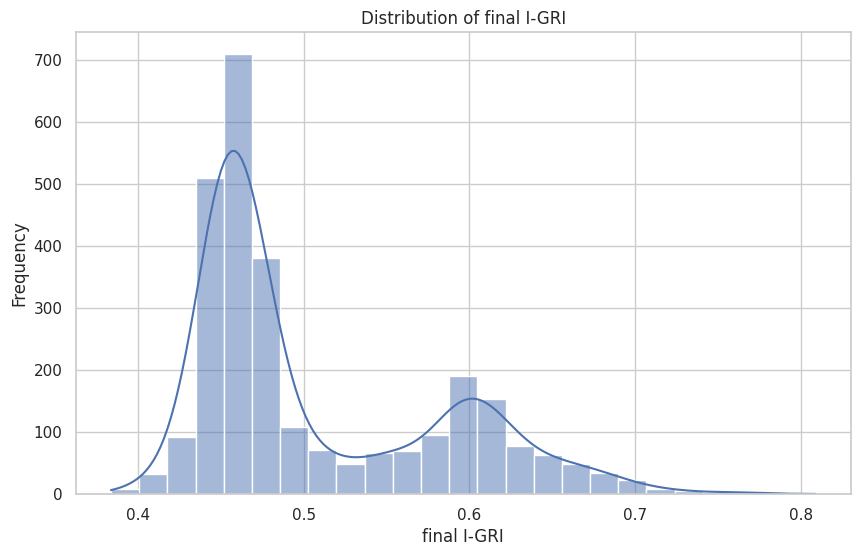

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')

plt.figure(figsize=(10, 6))
sns.histplot(data['final_I-GRI'], kde=True)

plt.title('Distribution of final I-GRI')
plt.xlabel('final I-GRI')
plt.ylabel('Frequency')

plt.show()

In [42]:
import numpy as np

non_image_features = data[['gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size', 'final_I-GRI']]

train_features1, train_labels1 = extract_features(trainGen1, trainGen1.samples)
val_features1, val_labels1 = extract_features(valGen1, valGen1.samples)
test_features1, test_labels1 = extract_features(testGen1, testGen1.samples)

train_features2, train_labels2 = extract_features(trainGen2, trainGen2.samples)
val_features2, val_labels2 = extract_features(valGen2, valGen2.samples)
test_features2, test_labels2 = extract_features(testGen2, testGen2.samples)

train_features3, train_labels3 = extract_features(trainGen3, trainGen3.samples)
val_features3, val_labels3 = extract_features(valGen3, valGen3.samples)
test_features3, test_labels3 = extract_features(testGen3, testGen3.samples)


def combine_all_features(features_list, non_image_data, indices):

    combined_features = np.concatenate(features_list, axis=1)
    
    non_image_features = non_image_data.iloc[indices].to_numpy()
    
    combined_features = np.concatenate((combined_features, non_image_features), axis=1)
    
    return combined_features


train_features_combined = combine_all_features(
    [train_features1, train_features2, train_features3],
    non_image_features,
    trainGen1.index_array 
)

val_features_combined = combine_all_features(
    [val_features1, val_features2, val_features3],
    non_image_features,
    valGen1.index_array
)

test_features_combined = combine_all_features(
    [test_features1, test_features2, test_features3],
    non_image_features,
    testGen1.index_array
)

train_labels = train_labels1
val_labels = val_labels1
test_labels = test_labels1


2024-03-28 12:48:35.399394: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-28 12:48:36.169167: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-28 12:48:38.682406: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 23ms/step


In [43]:
train_features_combined

array([[-0.028428949415683746, 2.5901966094970703, 0.1590651273727417,
        ..., 0.12234148280659908, 0.19509261486649027,
        0.6416060534376197],
       [-0.04442257434129715, 6.87844181060791, -0.031695619225502014,
        ..., 0.09938382031405288, 0.2996552000641488, 0.4689568535768689],
       [-0.025973357260227203, 0.8685999512672424, -0.061139728873968124,
        ..., 0.05674816139932419, 0.11490658327319381, 0.440533836829177],
       ...,
       [-0.05074585601687431, 4.673433303833008, 0.8463669419288635, ...,
        0.33621546412244085, 0.23109614305188036, 0.6803402457109387],
       [0.048553138971328735, 5.074797630310059, 0.2442377805709839, ...,
        0.11707414032995428, 0.29925426990618237, 0.47088685035843014],
       [0.2783464789390564, 5.184484481811523, 0.3417325019836426, ...,
        0.057245080500894455, 0.1444150428995269, 0.4443665746007235]],
      dtype=object)

In [44]:
from sklearn.svm import SVC

with tf.device('/GPU:0'):

    svm_model = SVC(kernel='linear', probability=True)
    svm_model.fit(train_features_combined, train_labels)

In [45]:
val_accuracy = svm_model.score(val_features_combined, val_labels)
print('Validation accuracy:', val_accuracy)

test_accuracy = svm_model.score(test_features_combined, test_labels)
print('Test accuracy:', test_accuracy)

Validation accuracy: 0.7466666666666667
Test accuracy: 0.7361853832442068


In [46]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions = svm_model.predict(test_features_combined)

conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[362  66]
 [ 82  51]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.83       428
         1.0       0.44      0.38      0.41       133

    accuracy                           0.74       561
   macro avg       0.63      0.61      0.62       561
weighted avg       0.73      0.74      0.73       561



In [47]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=8, 
                                 weights='distance', 
                                 algorithm='auto', 
                                 leaf_size=30, 
                                 p=2, 
                                 metric='minkowski', 
                                 n_jobs=-1)
knn_model.fit(train_features_combined, train_labels)

KNeighborsClassifier(n_jobs=-1, n_neighbors=8, weights='distance')

In [48]:
val_accuracy = knn_model.score(val_features_combined, val_labels)
print('Validation accuracy:', val_accuracy)

test_accuracy = knn_model.score(test_features_combined, test_labels)
print('Test accuracy:', test_accuracy)

Validation accuracy: 0.7777777777777778
Test accuracy: 0.7843137254901961


In [49]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions = knn_model.predict(test_features_combined)

conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[407  21]
 [100  33]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.95      0.87       428
         1.0       0.61      0.25      0.35       133

    accuracy                           0.78       561
   macro avg       0.71      0.60      0.61       561
weighted avg       0.76      0.78      0.75       561



In [50]:
import xgboost as xgb

scale_pos_weight = class_weights_dict[0] / class_weights_dict[1]

xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
xgb_model.fit(train_features_combined, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [51]:
val_accuracy = xgb_model.score(val_features_combined, val_labels)
print('Validation accuracy:', val_accuracy)

test_accuracy = xgb_model.score(test_features_combined, test_labels)
print('Test accuracy:', test_accuracy)

Validation accuracy: 0.8088888888888889
Test accuracy: 0.7878787878787878


In [52]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions = xgb_model.predict(test_features_combined)

conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[416  12]
 [107  26]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.97      0.87       428
         1.0       0.68      0.20      0.30       133

    accuracy                           0.79       561
   macro avg       0.74      0.58      0.59       561
weighted avg       0.77      0.79      0.74       561



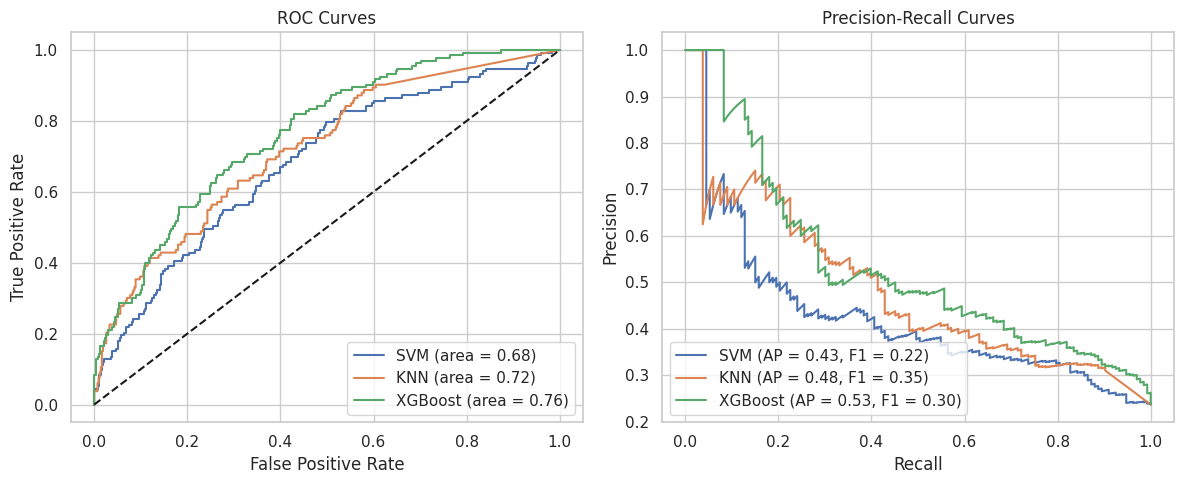

In [53]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, average_precision_score
import matplotlib.pyplot as plt

true_labels = test_labels
svm_probs = svm_model.predict_proba(test_features_combined)[:, 1]

knn_probs = knn_model.predict_proba(test_features_combined)[:, 1]

xgb_probs = xgb_model.predict_proba(test_features_combined)[:, 1]

fpr_svm, tpr_svm, _ = roc_curve(true_labels, svm_probs)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_knn, tpr_knn, _ = roc_curve(true_labels, knn_probs)
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_xgb, tpr_xgb, _ = roc_curve(true_labels, xgb_probs)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

precision_svm, recall_svm, _ = precision_recall_curve(true_labels, svm_probs)
ap_svm = average_precision_score(true_labels, svm_probs)
f1_svm = f1_score(true_labels, svm_probs.round())

precision_knn, recall_knn, _ = precision_recall_curve(true_labels, knn_probs)
ap_knn = average_precision_score(true_labels, knn_probs)
f1_knn = f1_score(true_labels, knn_probs.round())

precision_xgb, recall_xgb, _ = precision_recall_curve(true_labels, xgb_probs)
ap_xgb = average_precision_score(true_labels, xgb_probs)
f1_xgb = f1_score(true_labels, xgb_probs.round())

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (area = {roc_auc_svm:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (area = {roc_auc_knn:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall_svm, precision_svm, label=f'SVM (AP = {ap_svm:.2f}, F1 = {f1_svm:.2f})')
plt.plot(recall_knn, precision_knn, label=f'KNN (AP = {ap_knn:.2f}, F1 = {f1_knn:.2f})')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AP = {ap_xgb:.2f}, F1 = {f1_xgb:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()